Zad.4

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import urllib.request

%matplotlib inline

In [29]:
def read_input(problem_name):
    global n, A, B
    QAP_INSTANCE_URL = f'https://www.opt.math.tugraz.at/qaplib/data.d/{problem_name}'
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        if n==30:
            line += qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)

In [30]:
def qap_objective_function(p):
    s = 0.0
    for i in range(n):
        s += (A[i, :] * B[p[i], p]).sum()
    return s

In [31]:
def PMX(ind1, ind2):
    size = len(ind1)
    ancestor1 = np.full(size, -1)
    ancestor2 = np.full(size, -1)
    group_indices = np.random.choice(size, 2, False)
    group_begin, group_end = group_indices.min(), group_indices.max()
    ancestor1[group_begin:group_end+1]=ind2[group_begin:group_end+1]
    ancestor2[group_begin:group_end+1]=ind1[group_begin:group_end+1]
    mapping_first_to_second={}
    mapping_second_to_first={}
    for first_elem, second_elem in zip(ancestor1[group_begin:group_end+1], ancestor2[group_begin:group_end+1]):
        mapping_first_to_second[first_elem]=second_elem
        mapping_second_to_first[second_elem]=first_elem
    for i in range(size):
        if i < group_begin or i > group_end:
            if int(ind1[i]) not in mapping_first_to_second.keys():
                ancestor1[i]=ind1[i]
            else:
                selected_index=ind1[i]
                while(selected_index in  mapping_first_to_second.keys()):
                    selected_index=mapping_first_to_second[selected_index]
                ancestor1[i]=selected_index
            if ind2[i] not in mapping_second_to_first.keys():
                ancestor2[i]=ind2[i]
            else:
                selected_index=ind2[i]
                while(selected_index in  mapping_second_to_first.keys()):
                    selected_index=mapping_second_to_first[selected_index]
                ancestor2[i]=selected_index
    assert len(set(ancestor1)) == size
    assert len(set(ancestor2)) == size
    return ancestor1, ancestor2

In [32]:
def reverse_sequence_mutation(p):
    a = np.random.choice(len(p), 2, False)
    i, j = a.min(), a.max()
    q = p.copy()
    q[i:j+1] = q[i:j+1][::-1]
    return q

In [33]:
def SGA_PMX_QAP(population_size, chromosome_length, number_of_offspring, crossover_probability, mutation_probability, number_of_iterations, with_chart=False):
    time0 = time.time()
    best_objective_value = np.Inf
    best_chromosome = np.zeros((1, chromosome_length))
    costs = np.zeros(number_of_iterations)
    # generating an initial population
    current_population = np.zeros((population_size, chromosome_length), dtype=np.int64)
    for i in range(population_size):
        current_population[i, :] = np.random.permutation(chromosome_length)

    # evaluating the objective function on the current population
    objective_values = np.zeros(population_size)
    for i in range(population_size):
        objective_values[i] = qap_objective_function(current_population[i, :])

    for t in range(number_of_iterations):
    
        # selecting the parent indices by the roulette wheel method
        fitness_values = objective_values.max() - objective_values
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = np.ones(population_size) / population_size
        parent_indices = np.random.choice(population_size, number_of_offspring, True, fitness_values).astype(np.int64)

        # creating the children population
        children_population = np.zeros((number_of_offspring, chromosome_length), dtype=np.int64)
        for i in range(int(number_of_offspring/2)):
            if np.random.random() < crossover_probability:
                children_population[2*i, :], children_population[2*i+1, :] = PMX(current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1], :].copy())
            else:
                children_population[2*i, :], children_population[2*i+1, :] = current_population[parent_indices[2*i], :].copy(), current_population[parent_indices[2*i+1]].copy()
        if np.mod(number_of_offspring, 2) == 1:
            children_population[-1, :] = current_population[parent_indices[-1], :]

        # mutating the children population
        for i in range(number_of_offspring):
            if np.random.random() < mutation_probability:
                children_population[i, :] = reverse_sequence_mutation(children_population[i, :])

        # evaluating the objective function on the children population
        children_objective_values = np.zeros(number_of_offspring)
        for i in range(number_of_offspring):
            children_objective_values[i] = qap_objective_function(children_population[i, :])

        # replacing the current population by (Mu + Lambda) Replacement
        objective_values = np.hstack([objective_values, children_objective_values])
        current_population = np.vstack([current_population, children_population])

        I = np.argsort(objective_values)
        current_population = current_population[I[:population_size], :]
        objective_values = objective_values[I[:population_size]]

        best_idx=np.argmin(objective_values)
        # recording some statistics
        
        if best_objective_value > objective_values[best_idx]:
            best_objective_value = objective_values[best_idx]
            best_chromosome = current_population[best_idx, :]
        costs[t]=best_objective_value
    if with_chart:
        plt.figure(figsize=(12,4))
        plt.plot(costs)
        plt.show()
    return best_objective_value, best_chromosome, time.time() - time0

Problem size: 12
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  5.  2.  4.  1.  0.  0.  6.  2.  1.  1.  1.]
 [ 5.  0.  3.  0.  2.  2.  2.  0.  4.  5.  0.  0.]
 [ 2.  3.  0.  0.  0.  0.  0.  5.  5.  2.  2.  2.]
 [ 4.  0.  0.  0.  5.  2.  2. 10.  0.  0.  5.  5.]
 [ 1.  2.  0.  5.  0. 10.  0.  0.  0.  5.  1.  1.]
 [ 0.  2.  0.  2. 10.  0.  5.  1.  1.  5.  4.  0.]
 [ 0.  2.  0.  2.  0.  5.  0. 10.  5.  2.  3.  3.]
 [ 6.  0.  5. 10.  0.  1. 10.  0.  0.  0.  5.  0.]
 [ 2.  4.  5.  0.  0.  1.  5.  0.  0.  0. 10. 10.]
 [ 1.  5.  2.  0.  5.  

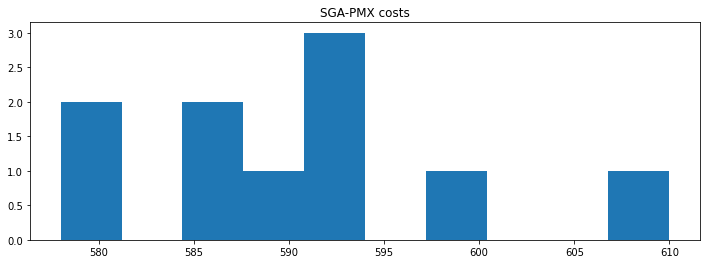

Problem size: 14
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.  1.  0.  2.  5.]
 [ 1.  2.  2.  1.  0.  3.  5.  5.  5.  1.  0.  3.  0.  5.]
 [ 0.  2.  0.  1.  3.  0.

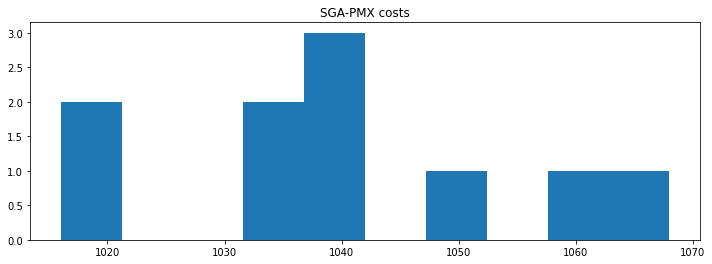

Problem size: 15
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0. 10.  0.  5.  1.  0.  1.  2.  2.  2.  2.  0.  4.  0.  0.]
 [10.  0.  1.  3.  2.  2.  2.  3.  2.  0.  2.  0. 10.  5.  0.]
 [ 0.  1.  0. 10.  2.  0.  2.  5.  4.  5.  2.  2.  5.  5.  5.]
 [ 5.  3. 10.  0.  1.  1.  5.  0.  0.  2.

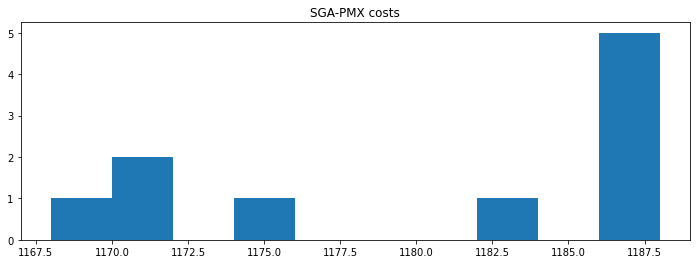

Problem size: 16
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  5.  2. 10.  3.  1.  5.  5.  5.  0.  0.  5.  4.]
 [ 0.  0.  3. 10.  5.  1.  5.  1.  2.  4.  2.  5.  0. 10. 10.  3.]


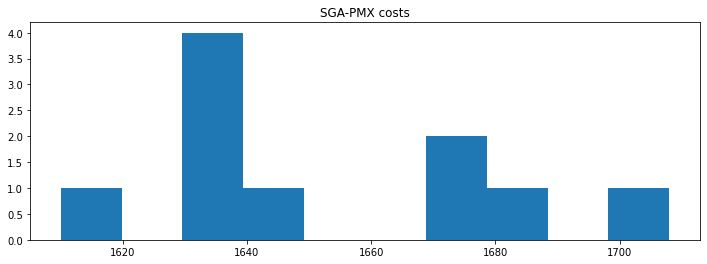

Problem size: 16
Flow matrix:
 [[0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5. 3. 4. 5. 6.]
 [1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4. 4. 3. 4. 5.]
 [2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3. 5. 4. 3. 4.]
 [3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2. 6. 5. 4. 3.]
 [1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4. 2. 3. 4. 5.]
 [2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3. 3. 2. 3. 4.]
 [3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2. 4. 3. 2. 3.]
 [4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1. 5. 4. 3. 2.]
 [2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3. 1. 2. 3. 4.]
 [3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2. 2. 1. 2. 3.]
 [4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1. 3. 2. 1. 2.]
 [5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0. 4. 3. 2. 1.]
 [3. 4. 5. 6. 2. 3. 4. 5. 1. 2. 3. 4. 0. 1. 2. 3.]
 [4. 3. 4. 5. 3. 2. 3. 4. 2. 1. 2. 3. 1. 0. 1. 2.]
 [5. 4. 3. 4. 4. 3. 2. 3. 3. 2. 1. 2. 2. 1. 0. 1.]
 [6. 5. 4. 3. 5. 4. 3. 2. 4. 3. 2. 1. 3. 2. 1. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  2. 10.  3.  1.  5.  5.  0.  0.  4.  4.  0.  0.]
 [ 0.  0.  3. 10.  1.  5.  1.  2.  2.  5.  0. 10.  3.  0.  5. 10.]


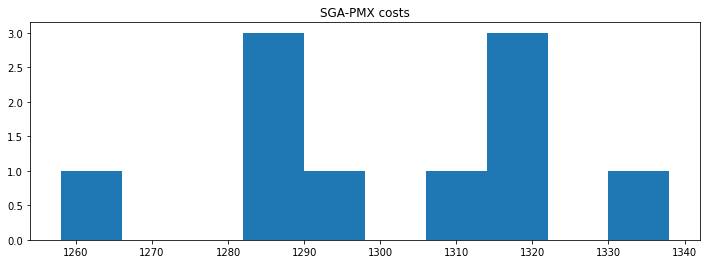

Problem size: 17
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1.]
 [4. 3. 4. 5. 6. 3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0.]]
Distance matrix:
 [[ 0.  0.  5.  0.  5.  2. 10.  3

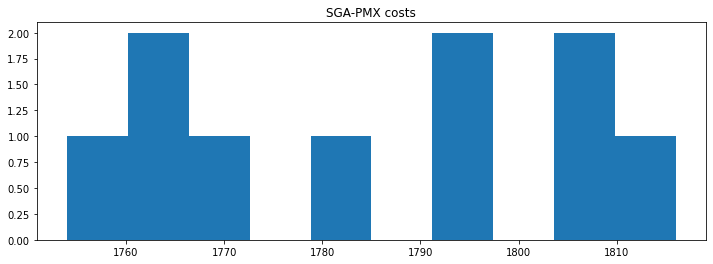

Problem size: 18
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3.]
 [3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2.]
 [4. 3. 4. 5. 6. 3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1.]


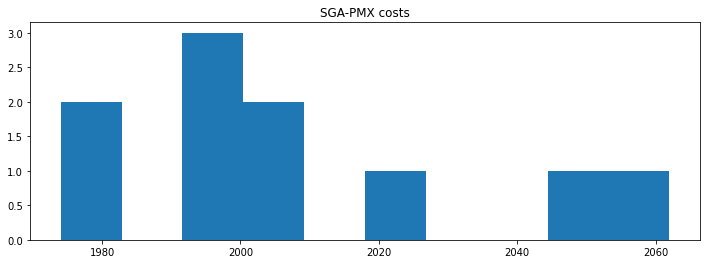

Problem size: 20
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5. 6. 7.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5. 6.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4. 3. 4.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4.]
 [4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3.]
 [5. 4. 3. 2. 3. 4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2.]
 [6. 5. 4. 3. 2. 5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1.]
 [3. 4. 5. 6. 7. 2. 3. 4

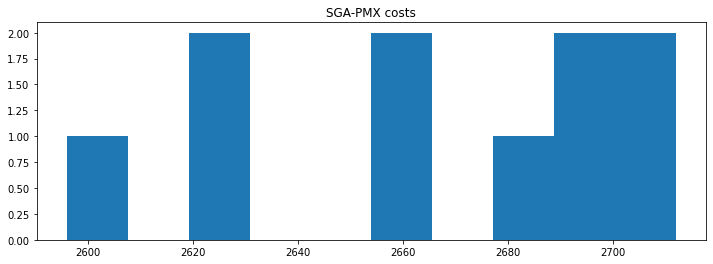

Problem size: 21
Flow matrix:
 [[0. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 7. 2. 3. 4. 5. 6. 7. 8.]
 [1. 0. 1. 2. 3. 4. 5. 2. 1. 2. 3. 4. 5. 6. 3. 2. 3. 4. 5. 6. 7.]
 [2. 1. 0. 1. 2. 3. 4. 3. 2. 1. 2. 3. 4. 5. 4. 3. 2. 3. 4. 5. 6.]
 [3. 2. 1. 0. 1. 2. 3. 4. 3. 2. 1. 2. 3. 4. 5. 4. 3. 2. 3. 4. 5.]
 [4. 3. 2. 1. 0. 1. 2. 5. 4. 3. 2. 1. 2. 3. 6. 5. 4. 3. 2. 3. 4.]
 [5. 4. 3. 2. 1. 0. 1. 6. 5. 4. 3. 2. 1. 2. 7. 6. 5. 4. 3. 2. 3.]
 [6. 5. 4. 3. 2. 1. 0. 7. 6. 5. 4. 3. 2. 1. 8. 7. 6. 5. 4. 3. 2.]
 [1. 2. 3. 4. 5. 6. 7. 0. 1. 2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 6. 7.]
 [2. 1. 2. 3. 4. 5. 6. 1. 0. 1. 2. 3. 4. 5. 2. 1. 2. 3. 4. 5. 6.]
 [3. 2. 1. 2. 3. 4. 5. 2. 1. 0. 1. 2. 3. 4. 3. 2. 1. 2. 3. 4. 5.]
 [4. 3. 2. 1. 2. 3. 4. 3. 2. 1. 0. 1. 2. 3. 4. 3. 2. 1. 2. 3. 4.]
 [5. 4. 3. 2. 1. 2. 3. 4. 3. 2. 1. 0. 1. 2. 5. 4. 3. 2. 1. 2. 3.]
 [6. 5. 4. 3. 2. 1. 2. 5. 4. 3. 2. 1. 0. 1. 6. 5. 4. 3. 2. 1. 2.]
 [7. 6. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 1. 0. 7. 6. 5. 4. 3. 2. 1.]
 [2. 3. 4. 5. 6. 7. 8. 1. 2. 3. 4. 5. 6. 7. 0

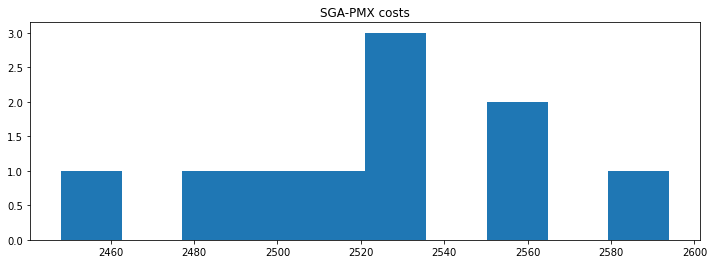

Problem size: 22
Flow matrix:
 [[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.  1.  2.  3.  4.  5.  6.  7.
   8.  9. 10. 11.]
 [ 1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9.  2.  1.  2.  3.  4.  5.  6.
   7.  8.  9. 10.]
 [ 2.  1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  3.  2.  1.  2.  3.  4.  5.
   6.  7.  8.  9.]
 [ 3.  2.  1.  0.  1.  2.  3.  4.  5.  6.  7.  4.  3.  2.  1.  2.  3.  4.
   5.  6.  7.  8.]
 [ 4.  3.  2.  1.  0.  1.  2.  3.  4.  5.  6.  5.  4.  3.  2.  1.  2.  3.
   4.  5.  6.  7.]
 [ 5.  4.  3.  2.  1.  0.  1.  2.  3.  4.  5.  6.  5.  4.  3.  2.  1.  2.
   3.  4.  5.  6.]
 [ 6.  5.  4.  3.  2.  1.  0.  1.  2.  3.  4.  7.  6.  5.  4.  3.  2.  1.
   2.  3.  4.  5.]
 [ 7.  6.  5.  4.  3.  2.  1.  0.  1.  2.  3.  8.  7.  6.  5.  4.  3.  2.
   1.  2.  3.  4.]
 [ 8.  7.  6.  5.  4.  3.  2.  1.  0.  1.  2.  9.  8.  7.  6.  5.  4.  3.
   2.  1.  2.  3.]
 [ 9.  8.  7.  6.  5.  4.  3.  2.  1.  0.  1. 10.  9.  8.  7.  6.  5.  4.
   3.  2.  1.  2.]
 [10.  9.  8.  7.  6.  5.  4.  3.  2.  

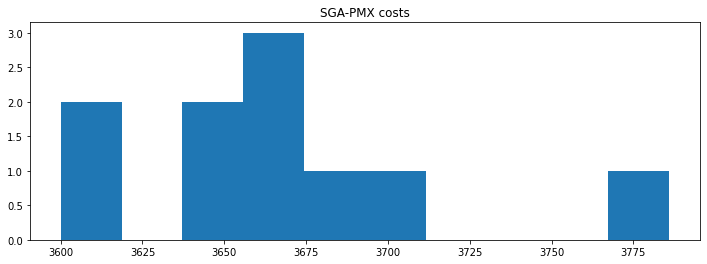

Problem size: 24
Flow matrix:
 [[0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7. 3. 4. 5. 6. 7. 8.]
 [1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6. 4. 3. 4. 5. 6. 7.]
 [2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5. 5. 4. 3. 4. 5. 6.]
 [3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4. 6. 5. 4. 3. 4. 5.]
 [4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3. 7. 6. 5. 4. 3. 4.]
 [5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2. 8. 7. 6. 5. 4. 3.]
 [1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7.]
 [2. 1. 2. 3. 4. 5. 1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6.]
 [3. 2. 1. 2. 3. 4. 2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5.]
 [4. 3. 2. 1. 2. 3. 3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4.]
 [5. 4. 3. 2. 1. 2. 4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3.]
 [6. 5. 4. 3. 2. 1. 5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2.]
 [2. 3. 4. 5. 6. 7. 1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5

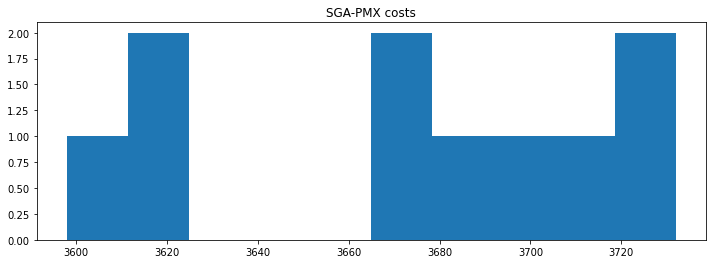

Problem size: 25
Flow matrix:
 [[0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5. 6. 7. 4. 5. 6. 7.
  8.]
 [1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5. 6. 5. 4. 5. 6.
  7.]
 [2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5. 6. 5. 4. 5.
  6.]
 [3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4. 3. 4. 7. 6. 5. 4.
  5.]
 [4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5. 4. 3. 8. 7. 6. 5.
  4.]
 [1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5. 6. 3. 4. 5. 6.
  7.]
 [2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4. 5.
  6.]
 [3. 2. 1. 2. 3. 2. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4. 5. 4. 3. 4.
  5.]
 [4. 3. 2. 1. 2. 3. 2. 1. 0. 1. 4. 3. 2. 1. 2. 5. 4. 3. 2. 3. 6. 5. 4. 3.
  4.]
 [5. 4. 3. 2. 1. 4. 3. 2. 1. 0. 5. 4. 3. 2. 1. 6. 5. 4. 3. 2. 7. 6. 5. 4.
  3.]
 [2. 3. 4. 5. 6. 1. 2. 3. 4. 5. 0. 1. 2. 3. 4. 1. 2. 3. 4. 5. 2. 3. 4. 5.
  6.]
 [3. 2. 3. 4. 5. 2. 1. 2. 3. 4. 1. 0. 1. 2. 3. 2. 1. 2. 3. 4. 3. 2. 3. 4.
  5.]
 [4. 3. 2

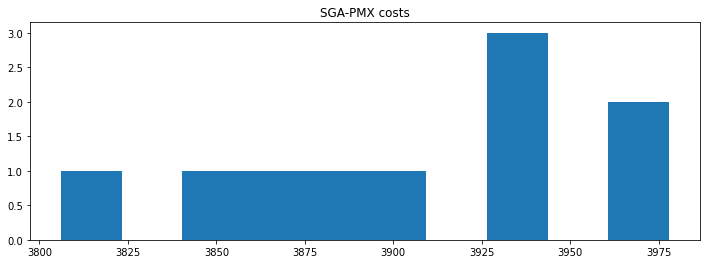

Problem size: 27
Flow matrix:
 [[ 0.  3.  2.  0.  0.  2. 10.  5.  0.  5.  2.  5.  0.  0.  2.  0.  5.  6.
   3.  0.  1. 10.  0. 10.  2.  1.  1.]
 [ 3.  0.  4.  0. 10.  4.  0.  0.  2.  2.  1.  0.  5.  0.  0.  0.  0.  2.
   0.  1.  6.  1.  0.  1.  2.  2.  5.]
 [ 2.  4.  0.  3.  4.  0.  5.  5.  5.  1.  4.  1.  0.  4.  0.  4.  0.  6.
   3.  2.  5.  5.  2.  1.  0.  0.  3.]
 [ 0.  0.  3.  0.  0.  0.  0.  2.  2.  0.  6.  0.  2.  5.  2.  5.  1.  1.
   1.  1.  2.  2.  4.  0.  2.  0.  2.]
 [ 0. 10.  4.  0.  0.  5.  2.  0.  0.  0.  0.  2.  0.  0.  0.  0.  2.  1.
   0.  0.  2.  0.  5.  1.  0.  2.  1.]
 [ 2.  4.  0.  0.  5.  0.  1.  2.  2.  1.  4. 10. 10.  2.  5.  5.  0.  5.
   0.  0.  0. 10.  0.  0.  0.  4.  0.]
 [10.  0.  5.  0.  2.  1.  0. 10. 10.  5. 10. 10.  6.  0.  0. 10.  2.  1.
  10.  1.  5.  5.  2.  3.  5.  0.  2.]
 [ 5.  0.  5.  2.  0.  2. 10.  0.  1.  3.  5.  0.  0.  0.  2.  4.  5.  2.
  10.  6.  0.  5.  5.  2.  5.  0.  5.]
 [ 0.  2.  5.  2.  0.  2. 10.  1.  0. 10.  2.  1.  5.  2.  0.  3.

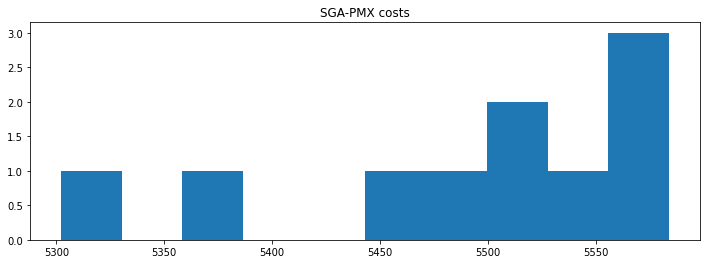

Problem size: 30
Flow matrix:
 [[0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7. 3. 4. 5. 6. 7. 8.
  4. 5. 6. 7. 8. 9.]
 [1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6. 4. 3. 4. 5. 6. 7.
  5. 4. 5. 6. 7. 8.]
 [2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5. 5. 4. 3. 4. 5. 6.
  6. 5. 4. 5. 6. 7.]
 [3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4. 6. 5. 4. 3. 4. 5.
  7. 6. 5. 4. 5. 6.]
 [4. 3. 2. 1. 0. 1. 5. 4. 3. 2. 1. 2. 6. 5. 4. 3. 2. 3. 7. 6. 5. 4. 3. 4.
  8. 7. 6. 5. 4. 5.]
 [5. 4. 3. 2. 1. 0. 6. 5. 4. 3. 2. 1. 7. 6. 5. 4. 3. 2. 8. 7. 6. 5. 4. 3.
  9. 8. 7. 6. 5. 4.]
 [1. 2. 3. 4. 5. 6. 0. 1. 2. 3. 4. 5. 1. 2. 3. 4. 5. 6. 2. 3. 4. 5. 6. 7.
  3. 4. 5. 6. 7. 8.]
 [2. 1. 2. 3. 4. 5. 1. 0. 1. 2. 3. 4. 2. 1. 2. 3. 4. 5. 3. 2. 3. 4. 5. 6.
  4. 3. 4. 5. 6. 7.]
 [3. 2. 1. 2. 3. 4. 2. 1. 0. 1. 2. 3. 3. 2. 1. 2. 3. 4. 4. 3. 2. 3. 4. 5.
  5. 4. 3. 4. 5. 6.]
 [4. 3. 2. 1. 2. 3. 3. 2. 1. 0. 1. 2. 4. 3. 2. 1. 2. 3. 5. 4. 3. 2. 3. 4.
  6. 5. 4. 3. 4. 5.]
 [5. 4. 3. 2. 1. 2.

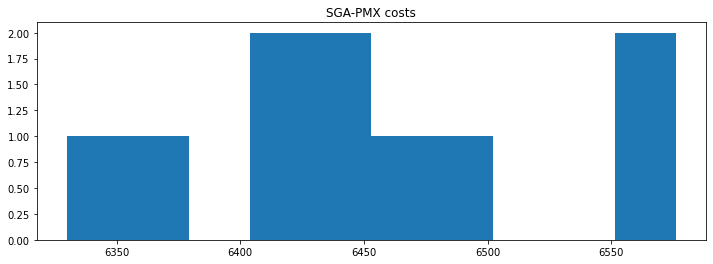

In [34]:
nug_problems=["nug12.dat", "nug14.dat", "nug15.dat", "nug16a.dat", "nug16b.dat", "nug17.dat", "nug18.dat", "nug20.dat", "nug21.dat"
         , "nug22.dat", "nug24.dat", "nug25.dat", "nug27.dat", "nug30.dat"]
population_size = 500
number_of_offspring = population_size
crossover_probability = 0.95
mutation_probability = 0.25
number_of_iterations = 250
for problem in nug_problems:
    try:
        read_input(problem)
        results=np.zeros(10)
        for i in range(10):
            chromosome_length = n
            best_res, best_perm, duration = SGA_PMX_QAP(population_size, chromosome_length, number_of_offspring, crossover_probability, mutation_probability, number_of_iterations)
            print(f"Permutation {best_perm} gives value {best_res} in time {duration}")
            results[i]=best_res
        plt.figure(figsize=(12,4))
        plt.title("SGA-PMX costs")
        plt.hist(results)
        plt.show()
    except HTTPError:        
        pass

In [42]:
def read_tai_input(problem_name):
    global n, A, B
    QAP_INSTANCE_URL = f'https://www.opt.math.tugraz.at/qaplib/data.d/{problem_name}'
    qap_instance_file = urllib.request.urlopen(QAP_INSTANCE_URL)

    line = qap_instance_file.readline()
    n = int(line.decode()[:-1].split()[0])
    print('Problem size: %d' % n)

    A = np.empty((n, n))
    for i in range(n):
        line = qap_instance_file.readline()
        A[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Flow matrix:\n', A)

    B = np.empty((n, n))
    if n != 50:
        qap_instance_file.readline()
    for i in range(n):
        line = qap_instance_file.readline()
        #if n==80:
        #line += qap_instance_file.readline()
        B[i, :] = list(map(int, line.decode()[:-1].split()))
    print('Distance matrix:\n', B)

Problem size: 50
Flow matrix:
 [[ 0. 21. 95. ... 11. 29. 82.]
 [21.  0. 82. ... 83. 96. 74.]
 [95. 82.  0. ... 89. 48. 14.]
 ...
 [11. 83. 89. ...  0. 94. 53.]
 [29. 96. 48. ... 94.  0.  6.]
 [82. 74. 14. ... 53.  6.  0.]]
Distance matrix:
 [[ 0. 97. 20. ... 80. 10. 78.]
 [97.  0. 55. ... 91. 45. 83.]
 [20. 55.  0. ... 19. 67. 42.]
 ...
 [80. 91. 19. ...  0. 80. 40.]
 [10. 45. 67. ... 80.  0. 20.]
 [78. 83. 42. ... 40. 20.  0.]]
Permutation [43 34 30 20 19 24 17 12  5 26 44 21 18 36  9 45 48 11 28 16 38  8 40 13
 23 29 39 33 15 47 35 32 14 27  2 31 49  1 22 37 10  3  6  7 42  4  0 41
 25 46] gives value 5378908.0 in time 92.22599124908447
Permutation [46 21 43 41 32 47 37 33 18  2 30  7 26 15 42  5 22 20 48 19 17 25 16 31
 38 12 36 11  0  3 39 35  9  8 13 27 28  6  1 49 14 45  4 44 24 10 23 40
 29 34] gives value 5351732.0 in time 92.49500250816345
Permutation [ 0 47 39 46 11 35 18 45  3 49 19 24 15 10 17  1  6 22 44 16 40 28 48 20
 38 36 23 12 26  5 31 21 41 25 13 33 27  4  2 29  7 37

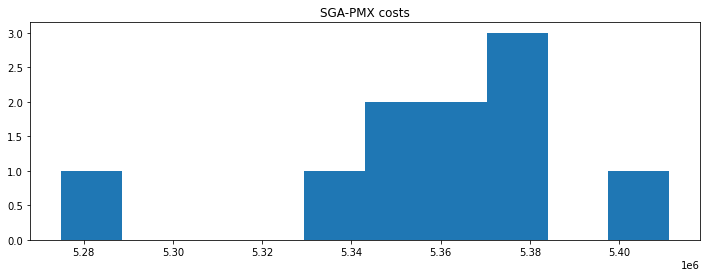

Problem size: 60
Flow matrix:
 [[ 0. 79. 71. ... 64. 87. 53.]
 [79.  0. 98. ... 69. 81. 99.]
 [71. 98.  0. ... 17. 24. 27.]
 ...
 [64. 69. 17. ...  0. 73. 78.]
 [87. 81. 24. ... 73.  0.  3.]
 [53. 99. 27. ... 78.  3.  0.]]
Distance matrix:
 [[ 0. 21. 95. ... 89. 76. 76.]
 [21.  0. 40. ... 11. 77. 32.]
 [95. 40.  0. ...  8. 38. 41.]
 ...
 [89. 11.  8. ...  0. 32. 56.]
 [76. 77. 38. ... 32.  0. 26.]
 [76. 32. 41. ... 56. 26.  0.]]
Permutation [51  5 33 29 22 36 10 55 58 16 34  6 57 39 45  2 47 28 42 12 44 56  1 30
 41 25  8  4 27 37 13 18 11 32 31 23  7 17 14 54 38 43 52 35 15 59 50 20
 26 46 21 53  9  3 48 40 49  0 19 24] gives value 7849622.0 in time 110.35699772834778
Permutation [26  9 16 49 22  8 24 14 54 25 18 31 48 57  6  0 27 32 47 59 28 50 45 29
  7  2 51 44 37  5 53 17 46 12  1 33 40 21 11 36 41 42 23 38 56 34  4 52
  3 20 10 55 30 43 19 58 39 13 15 35] gives value 7814126.0 in time 111.30800080299377
Permutation [10 30  6 11  5 14 54 32 26 42 57  2 24 18 25 55 16 39 53 34 22 1

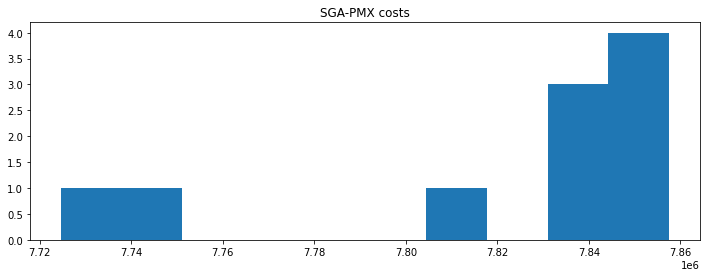

Problem size: 80
Flow matrix:
 [[ 0. 64. 51. ... 66. 87. 45.]
 [64.  0. 28. ... 21. 69. 21.]
 [51. 28.  0. ... 96.  7.  4.]
 ...
 [66. 21. 96. ...  0. 73.  3.]
 [87. 69.  7. ... 73.  0. 53.]
 [45. 21.  4. ...  3. 53.  0.]]
Distance matrix:
 [[ 0. 21. 95. ... 61. 80. 58.]
 [21.  0. 21. ... 62. 46. 25.]
 [95. 21.  0. ... 33. 35. 61.]
 ...
 [61. 62. 33. ...  0. 66. 43.]
 [80. 46. 35. ... 66.  0. 82.]
 [58. 25. 61. ... 43. 82.  0.]]
Permutation [64 74 44 43 39 29 21 73 16 63 42 20 55 60 56 53 69 33 41 17 58 36  3 50
 57 48 18 59 51  2 27  5 71 47  7 11 35 72 66 75 37 46 52 30  4 62 68  6
 31 22 32 26 76  0 49 70 19 10 24 67 77 65 78  1 54 45  9 79 14 28 40 34
 13 38 23 15 61 25 12  8] gives value 14591204.0 in time 145.84298825263977
Permutation [41 72 50 14 21 73 56 55 34 43 29 70 61 31 30 11 67 36 48 37 39 42  2  9
 16 10 35 33  3 79 75 26 32 63  6 51 68 20 22  8 57 49 44 24 12 64 40 74
 27 62 69 53 28 23 76 60 38 19 78 59  0 13 46  5 77 25 58 18 17 15 65 54
 52  7  1 47 66 45 71  4] giv

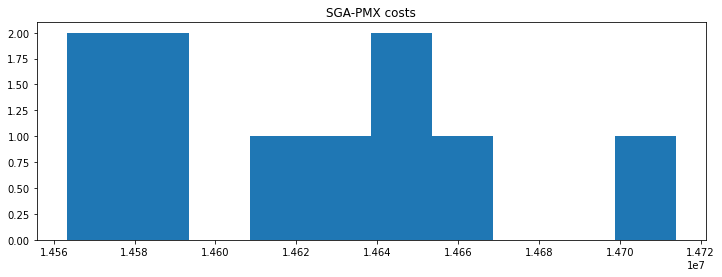

In [43]:
tai_problems=["tai50a.dat", "tai60a.dat", "tai80a.dat"]
population_size = 500
number_of_offspring = population_size
crossover_probability = 0.95
mutation_probability = 0.25
number_of_iterations = 250
for problem in tai_problems:
    try:
        read_tai_input(problem)
        results=np.zeros(10)
        for i in range(10):
            chromosome_length = n
            best_res, best_perm, duration = SGA_PMX_QAP(population_size, chromosome_length, number_of_offspring, crossover_probability, mutation_probability, number_of_iterations)
            print(f"Permutation {best_perm} gives value {best_res} in time {duration}")
            results[i]=best_res
        plt.figure(figsize=(12,4))
        plt.title("SGA-PMX costs")
        plt.hist(results)
        plt.show()
    except HTTPError:        
        pass